In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# File Paths
data_path = "/Users/jakubriha/Desktop/ECO225/Project/Data/"
loans_file = data_path + "loans.csv"
kiva_loans_file = data_path + "kiva_loans.csv"
country_stats_file = data_path + "country_stats.csv"
loan_coords_file = data_path + "loan_coords.csv"

In [4]:
# Load and Merge Data
df1 = pd.read_csv(loans_file)
df2 = pd.read_csv(kiva_loans_file).rename(columns={'id': 'loan_id'})
merged_df = df1.merge(df2, on='loan_id', how='inner')

In [5]:
# Drop rows with missing values in key columns
required_columns = ['funded_amount_x', 'loan_amount_x', 'country_code_x', 'borrower_genders_x']
filtered_df = merged_df.dropna(subset=required_columns).copy()

# Remove discrepancies in categorical columns
columns_to_check = ['country_code', 'currency', 'borrower_genders', 'repayment_interval']
for col in columns_to_check:
    filtered_df = filtered_df[filtered_df[f'{col}_x'] == filtered_df[f'{col}_y']]

# Keep only one version of duplicated columns
filtered_df = filtered_df.rename(columns={f'{col}_x': col for col in columns_to_check})
filtered_df.drop(columns=[f'{col}_y' for col in columns_to_check], inplace=True)

# Remove all variables with '_y' suffix and rename corresponding '_x' columns
columns_to_remove = [col for col in filtered_df.columns if col.endswith('_y')]
filtered_df.drop(columns=columns_to_remove, inplace=True)

columns_to_rename = {col: col[:-2] for col in filtered_df.columns if col.endswith('_x')}
filtered_df.rename(columns=columns_to_rename, inplace=True)

# Drop observations where 'raised_time' is empty
filtered_df.dropna(subset=['raised_time'], inplace=True)

In [6]:
# Merge with country stats
df_country = pd.read_csv(country_stats_file, usecols=['country_code', 'population', 'hdi'])
final_df = filtered_df.merge(df_country, on='country_code', how='left')

# Merge with loan coordinates
df_coords = pd.read_csv(loan_coords_file)
final_df = final_df.merge(df_coords, on='loan_id', how='left')

# Function to classify gender
def classify_gender(gender_str):
    if pd.isna(gender_str):
        return np.nan  # Handle missing values
    genders = set(gender_str.lower().replace(' ', '').split(','))
    if genders == {'female'}:
        return 'female'
    elif genders == {'male'}:
        return 'male'
    else:
        return 'mixed'

# Apply the classification to the 'borrower_genders' column
final_df['gender_group'] = final_df['borrower_genders'].apply(classify_gender)

# Convert gender categories to dummy variables for regression
# This will create 'gender_group_female' and 'gender_group_mixed', using 'male' as the reference category
gender_dummies = pd.get_dummies(final_df['gender_group'], prefix='gender_group', drop_first=True)

# Concatenate dummy variables with the main dataframe
final_df = pd.concat([final_df, gender_dummies], axis=1)

# Drop empty observations for HDI and duplicate columns
# Drop empty observations for HDI, latitude, and longitude
final_df.dropna(subset=['hdi', 'latitude', 'longitude'], inplace=True)
final_df.drop(columns=['activity_name', 'sector_name', 'loan_use', 'currency_policy', 
                        'currency_exchange_coverage_rate', 'currency', 
                        'num_journal_entries', 'num_bulk_entries', 
                        'distribution_model', 'region'], inplace=True)

In [7]:
# Calculate funding time in days
final_df['funding_time_days'] = (pd.to_datetime(final_df['raised_time']) - pd.to_datetime(final_df['posted_time'])).dt.total_seconds() / (60 * 60 * 24)
final_df = final_df[final_df['funding_time_days'] > 0]
final_df['log_funding_time'] = np.log(final_df['funding_time_days'])

# Create sector fixed effects (one-hot encoding)
sector_dummies = pd.get_dummies(final_df['sector'], prefix='sector', drop_first=True)
final_df = pd.concat([final_df, sector_dummies], axis=1)

# Aggregate the number of loans per country
loan_counts = final_df.groupby('country_code').size().reset_index(name='loan_count')

In [8]:
# Convert all sector dummy variables from bool to int
sector_columns = [col for col in final_df.columns if col.startswith('sector_')]
final_df[sector_columns] = final_df[sector_columns].astype(int)

In [20]:
# Summary statistics for each variable
summary_stats = pd.DataFrame({
    'Variable Name': final_df.columns,
    'Data Type': final_df.dtypes.values,
    'Unique Values': final_df.nunique().values,
    'Non-Null Count': final_df.notnull().sum().values,
    'Missing Values': final_df.isnull().sum().values
})

# Display the summary
summary_stats

Variable Name Data Type  Unique Values  Non-Null Count  \
0                   loan_id     int64         550640          550640   
1                 loan_name    object         148221          550426   
2         original_language    object              5          550640   
3               description    object         550446          550637   
4    description_translated    object         543417          543583   
5             funded_amount   float64            461          550640   
6               loan_amount   float64            461          550640   
7                    status    object              1          550640   
8              country_code    object             77          550640   
9              country_name    object             77          550640   
10                town_name    object           9848          550640   
11               partner_id   float64            332          550640   
12              posted_time    object         548448          550640   
13  planned_expiration_time    object         293933          550640   
14            disburse_time    object           1656          550640   
15              raised_time    object         445229          550640   
16              lender_term   float64            147          550640   
17        num_lenders_total     int64            464          550640   
18                     tags    object          71920          406249   
19         borrower_genders    object           8318          550640   
20        borrower_pictured    object           3067          550640   
21       repayment_interval    object              3          550640   
22                 activity    object            163          550640   
23                   sector    object             15          550640   
24                      use    object         337591          550636   
25                  country    object             77          550640   
26           disbursed_time    object           1656          550640   
27              funded_time    object         440784          545553   
28           term_in_months   float64            147          550640   
29             lender_count     int64            464          550640   
30                     date    object           1292          550640   
31               population   float64             77          550640   
32                      hdi   float64             77          550640   
33                 latitude   float64           8329          550640   
34                longitude   float64           7516          550640   
35             gender_group    object              3          550640   
36        gender_group_male     int64              2          550640   
37       gender_group_mixed     int64              2          550640   
38        funding_time_days   float64         490591          550640   
39         log_funding_time   float64         490591          550640   
40              sector_Arts     int64              2          550640   
41          sector_Clothing     int64              2          550640   
42      sector_Construction     int64              2          550640   
43         sector_Education     int64              2          550640   
44     sector_Entertainment     int64              2          550640   
45              sector_Food     int64              2          550640   
46            sector_Health     int64              2          550640   
47           sector_Housing     int64              2          550640   
48     sector_Manufacturing     int64              2          550640   
49      sector_Personal Use     int64              2          550640   
50            sector_Retail     int64              2          550640   
51          sector_Services     int64              2          550640   
52    sector_Transportation     int64              2          550640   
53         sector_Wholesale     int64              2          550640   

    Missing Values  
0                0  
1          

In [9]:
# Convert boolean to integer (optional but recommended for regressions)
final_df[['gender_group_male', 'gender_group_mixed']] = final_df[['gender_group_male', 'gender_group_mixed']].astype(int)


In [18]:
# Save the cleaned data
save_dir = data_path
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

final_df.to_csv(os.path.join(save_dir, "data_df.csv"), index=False)

print(f"Dataset saved to: {os.path.join(save_dir, 'data_df.csv')}")

Dataset saved to: /Users/jakubriha/Desktop/ECO225/Project/Data/data_df.csv


/var/folders/11/xm61jt5j3bgcdskv3tnccjdh0000gn/T/ipykernel_57909/2281304706.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  world_loan_data['loan_count'].fillna(0, inplace=True)
/var/folders/11/xm61jt5j3bgcdskv3tnccjdh0000gn/T/ipykernel_57909/2281304706.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting valu

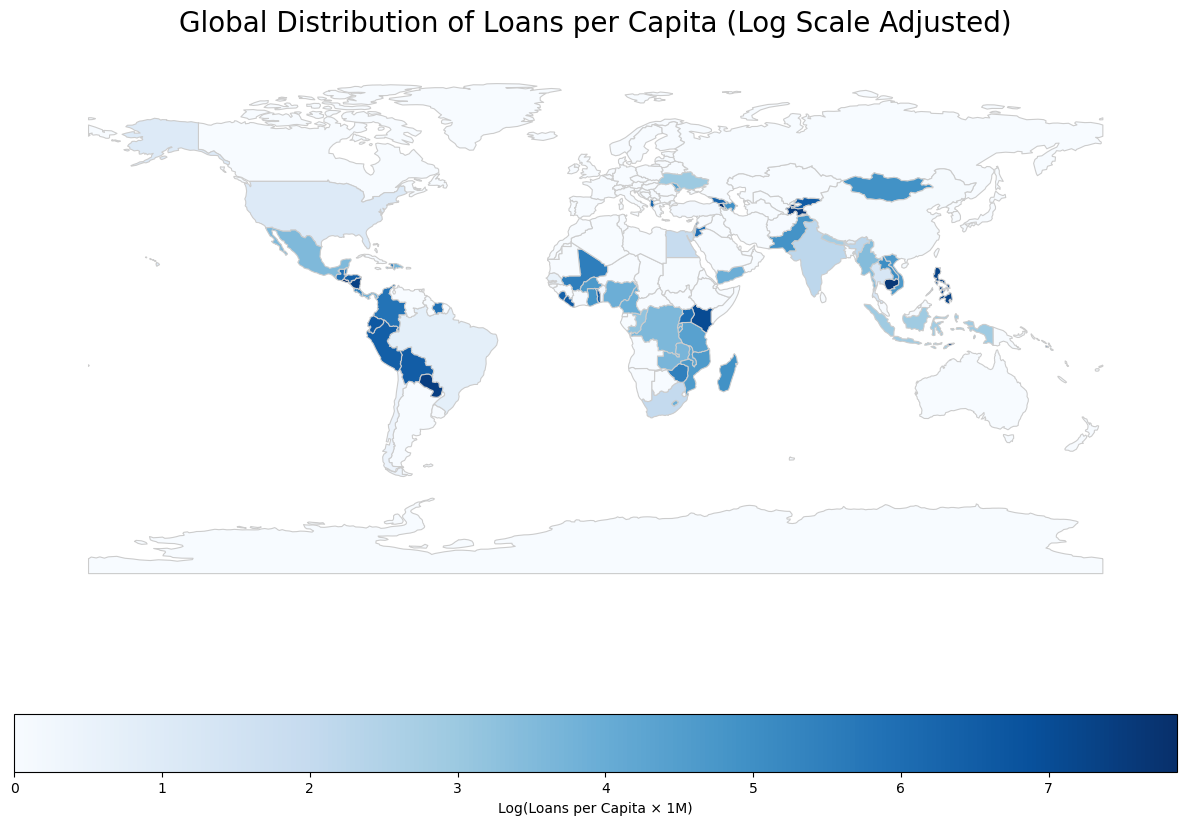

In [40]:
import pycountry
import matplotlib.pyplot as plt
import numpy as np

# Function to convert alpha-2 to alpha-3
def alpha2_to_alpha3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

# Apply the conversion
final_df['country_code_alpha3'] = final_df['country_code'].apply(alpha2_to_alpha3)

# Re-aggregate loan counts with alpha-3 codes
loan_counts = final_df.groupby('country_code_alpha3').size().reset_index(name='loan_count')

# Ensure population data is included for merging
population_data = final_df[['country_code_alpha3', 'population']].drop_duplicates()

# Merge with world shapefile using alpha-3 codes
world_loan_data = world.merge(loan_counts, how='left', left_on='ADM0_A3', right_on='country_code_alpha3')

# Merge population data
world_loan_data = world_loan_data.merge(population_data, how='left', on='country_code_alpha3')

# Fill missing loan counts and population with 0
world_loan_data['loan_count'].fillna(0, inplace=True)
world_loan_data['population'].fillna(1, inplace=True)  # Avoid division by zero

# Calculate loans per capita
world_loan_data['loans_per_capita'] = world_loan_data['loan_count'] / world_loan_data['population']
world_loan_data['loans_per_capita'].fillna(0, inplace=True)

# Scale up before applying log
world_loan_data['log_loans_per_capita'] = np.log1p(world_loan_data['loans_per_capita'] * 1e6)

# Plot with the improved log scale
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world_loan_data.plot(
    column='log_loans_per_capita',
    cmap='Blues',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    legend_kwds={'label': "Log(Loans per Capita × 1M)", 'orientation': "horizontal"}
)

ax.set_title('Global Distribution of Loans per Capita (Log Scale Adjusted)', fontdict={'fontsize': 20}, pad=20)
ax.set_axis_off()

plt.show()


In [104]:
from IPython.display import display, HTML

# Descriptive Statistics for Continuous Variables
continuous_vars = ['funding_time_days', 'loan_amount', 'hdi', 'lender_term', 'num_lenders_total']

# Descriptive statistics with proper formatting
summary_stats = final_df[continuous_vars].describe(percentiles=[0.25, 0.5, 0.75]).T

# Renaming columns and variables
summary_stats = summary_stats.rename(columns={
    'count': 'Observations',
    'mean': 'Mean',
    'std': 'Standard Deviation',
    'min': 'Min',
    '25%': '25th',
    '50%': 'Median',
    '75%': '75th',
    'max': 'Max'
})

# Proper variable names
variable_names = {
    'funding_time_days': 'Funding Time (Days)',
    'loan_amount': 'Loan Amount (USD)',
    'hdi': 'HDI (0-1)',
    'lender_term': 'Loan Term (Months)',
    'num_lenders_total': 'Number of Lenders (Per Loan)'
}
summary_stats.rename(index=variable_names, inplace=True)

# Formatting numbers to two decimal places, keeping 'Count' as an integer
summary_stats['Observations'] = summary_stats['Observations'].astype(int)
for col in ['Mean', 'Standard Deviation', 'Min', '25th', 'Median', '75th', 'Max']:
    summary_stats[col] = summary_stats[col].apply(lambda x: f'{x:.2f}')

# Reordering columns to place 'Count' first
summary_stats = summary_stats[['Observations', 'Mean', 'Standard Deviation', 'Min', 
                               '25th', 'Median', '75th', 'Max']]
# Apply styling to remove all row shading and center-align text
styled_summary_stats = (
    summary_stats.style
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', 'white')]},  # White background for headers
        {'selector': 'td', 'props': [('text-align', 'center'), ('background-color', 'white')]}   # White background for all data cells
    ])
)

# Apply styling to increase cell size and improve readability
styled_summary_stats = (
    summary_stats.style
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', 'white'), ('padding', '10px'), ('font-size', '12pt')]},  # Larger headers
        {'selector': 'td', 'props': [('text-align', 'center'), ('background-color', 'white'), ('padding', '10px'), ('font-size', '11pt')]},  # Larger data cells
        {'selector': 'th.row_levels', 'props': [('background-color', 'white')]},  # White background for multi-index labels
        {'selector': 'th.blank', 'props': [('background-color', 'white')]}        # White background for blank merged cells
    ])
)

# Add title
display(HTML("<h2 style='text-align: center;'>Table I: Descriptive Statistics for Continuous Variables</h2>"))

# Display the styled descriptive statistics table
styled_summary_stats

In [126]:
# Combine gender and sector dummy variables
gender_dummies = {
    'Male': final_df['gender_group_male'],
    'Female': (final_df['gender_group_male'] == 0) & (final_df['gender_group_mixed'] == 0),
    'Mixed': final_df['gender_group_mixed']
}

sector_columns = [col for col in final_df.columns if col.startswith('sector_')]

dummy_vars = {**gender_dummies, **{col.replace('sector_', ''): final_df[col] for col in sector_columns}}

# Create the summary statistics for dummy variables
dummy_summary = pd.DataFrame({
    'Observations': {k: int(v.sum()) for k, v in dummy_vars.items()},
    'Proportion (%)': {k: round(v.mean() * 100, 2) for k, v in dummy_vars.items()}
})

# Format the summary table with multi-index
formatted_dummy_summary = pd.DataFrame({
    'Variable': ['Gender' if cat in ['Male', 'Female', 'Mixed'] else 'Sector' for cat in dummy_summary.index],
    'Category': dummy_summary.index,
    'Observations': dummy_summary['Observations'].values,
    'Proportion (%)': dummy_summary['Proportion (%)'].values
})

formatted_dummy_summary.set_index(['Variable', 'Category'], inplace=True)

# Round Proportion (%) to 2 decimal places
formatted_dummy_summary['Proportion (%)'] = formatted_dummy_summary['Proportion (%)'].apply(lambda x: f'{x:.2f}')

# Add title with centered alignment
display(HTML("""
<div style='text-align: center;'>
    <h2>Table II: Summary of Gender & Sector Dummy Variables</h2>
</div>
"""))

# Apply styling to center the table using internal CSS
styled_table = (
    formatted_dummy_summary.style
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', 'white'), ('padding', '10px'), ('font-size', '12pt')]},
        {'selector': 'td', 'props': [('text-align', 'center'), ('background-color', 'white'), ('padding', '10px'), ('font-size', '11pt')]},
        {'selector': 'th.row_levels', 'props': [('background-color', 'white')]},
        {'selector': 'th.blank', 'props': [('background-color', 'white')]},
        {'selector': 'table', 'props': [('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]}  # Forces center alignment
    ])
)

# Display the centered table
styled_table

In [106]:
# Function to calculate statistics for male, female, and mixed groups
def calculate_stats(var):
    male_data = final_df[final_df['gender_group_male'] == 1][var]
    female_data = final_df[(final_df['gender_group_male'] == 0) & (final_df['gender_group_mixed'] == 0)][var]
    mixed_data = final_df[final_df['gender_group_mixed'] == 1][var]
    
    mean_male = male_data.mean()
    std_male = male_data.std()
    mean_female = female_data.mean()
    std_female = female_data.std()
    mean_mixed = mixed_data.mean()
    std_mixed = mixed_data.std()
    
    mean_diff = mean_male - mean_female
    std_diff = std_male - std_female
    
    return [mean_male, std_male, mean_female, std_female, mean_mixed, std_mixed, mean_diff, std_diff]

# Apply the function to all variables
continuous_vars = ['funding_time_days', 'loan_amount', 'hdi', 'lender_term', 'num_lenders_total']
variable_names = {
    'funding_time_days': 'Funding Time (Days)',
    'loan_amount': 'Loan Amount (USD)',
    'hdi': 'HDI (0-1)',
    'lender_term': 'Loan Term (Months)',
    'num_lenders_total': 'Number of Lenders (Per Loan)'
}

# Create DataFrame for summary
stats_data = {variable_names[var]: calculate_stats(var) for var in continuous_vars}

# Create DataFrame
stats_summary = pd.DataFrame.from_dict(stats_data, orient='index',
                                       columns=['Mean', 'S.D', 'Mean', 'S.D', 'Mean', 'S.D', 'Difference in Mean', 'Difference in S.D'])

# MultiIndex for header
header = pd.MultiIndex.from_tuples([
    ('Male', 'Mean'), ('Male', 'S.D'),
    ('Female', 'Mean'), ('Female', 'S.D'),
    ('Mixed', 'Mean'), ('Mixed', 'S.D'),
    ('Male - Female', 'Mean'), ('Male - Female', 'S.D')
])

# Apply the new header
stats_summary.columns = header

# Formatting numbers to two decimal places
stats_summary = stats_summary.map(lambda x: f'{x:.2f}')

# Apply clean styling with larger cell size
styled_table = (
    stats_summary.style
    .set_table_styles([
        {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', 'white'), ('padding', '10px'), ('font-size', '12pt')]},  
        {'selector': 'td', 'props': [('text-align', 'center'), ('background-color', 'white'), ('padding', '10px'), ('font-size', '11pt')]},  
        {'selector': 'th.row_levels', 'props': [('background-color', 'white')]},  
        {'selector': 'th.blank', 'props': [('background-color', 'white')]}       
    ])
)

# Add title
display(HTML("<h2 style='text-align: center;'>Table III: Gender-Based Summary Statistics with Differences</h2>"))

# Display the styled gender-based table
styled_table  # Replace this with your gender-based styled table variable

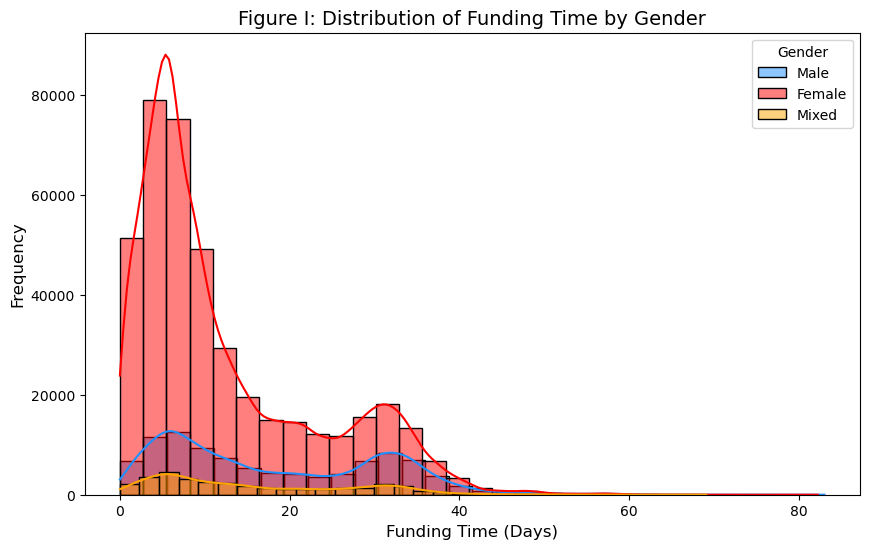

In [238]:
import matplotlib.colors as mcolors

# Define gender groups
male_funding_time = final_df.loc[final_df['gender_group_male'] == 1, 'funding_time_days']
female_funding_time = final_df.loc[(final_df['gender_group_male'] == 0) & (final_df['gender_group_mixed'] == 0), 'funding_time_days']
mixed_funding_time = final_df.loc[final_df['gender_group_mixed'] == 1, 'funding_time_days']

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(male_funding_time, bins=30, kde=True, color='dodgerblue', label='Male', alpha=0.5)
sns.histplot(female_funding_time, bins=30, kde=True, color='red', label='Female', alpha=0.5)
sns.histplot(mixed_funding_time, bins=30, kde=True, color='orange', label='Mixed', alpha=0.5)

# Labels and title
plt.xlabel('Funding Time (Days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Figure I: Distribution of Funding Time by Gender', fontsize=14)
plt.legend(title="Gender")

# Show the plot
plt.show()


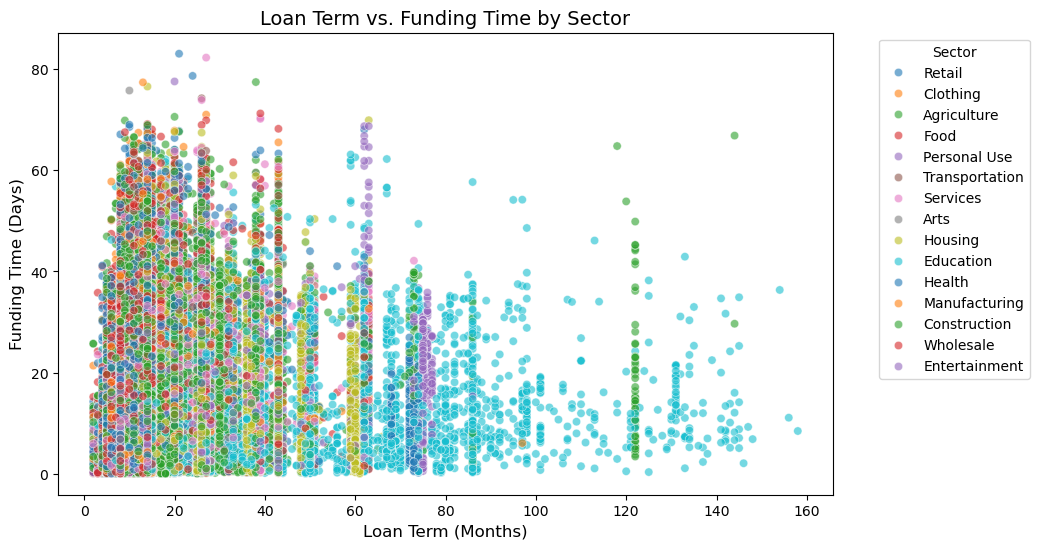

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(10, 6))

# Scatter plot with color-coded sectors
sns.scatterplot(
    data=final_df, 
    x='lender_term', 
    y='funding_time_days', 
    hue='sector',  # Color by sector
    alpha=0.6,  # Transparency to avoid overplotting
    palette='tab10'  # Use a qualitative color palette
)

# Labels and title
plt.xlabel('Loan Term (Months)', fontsize=12)
plt.ylabel('Funding Time (Days)', fontsize=12)
plt.title('Loan Term vs. Funding Time by Sector', fontsize=14)
plt.legend(title='Sector', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside

# Show plot
plt.show()


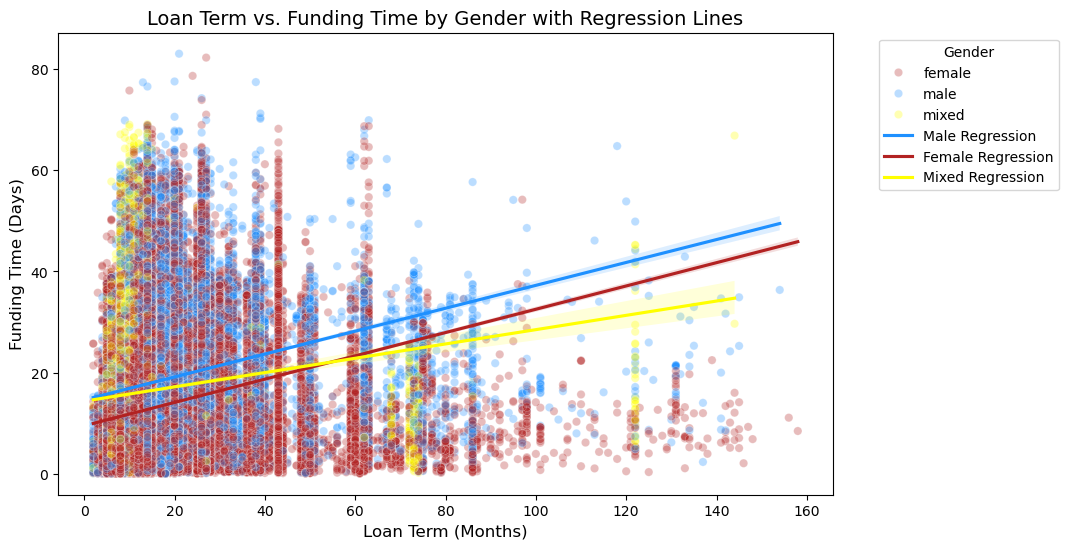

In [166]:

# Define color mapping for gender groups
gender_colors = {'male': 'dodgerblue', 'female': 'firebrick', 'mixed': 'yellow'}

# Set figure size
plt.figure(figsize=(10, 6))

# Scatter plot with color-coded gender groups
sns.scatterplot(data=final_df, x='lender_term', y='funding_time_days', hue='gender_group',
                palette=gender_colors, alpha=0.3)

# Add regression lines for each gender group
for gender, color in gender_colors.items():
    subset = final_df[final_df['gender_group'] == gender]
    sns.regplot(data=subset, x='lender_term', y='funding_time_days',
                scatter=False, color=color, label=f"{gender.capitalize()} Regression")

# Labels and title
plt.xlabel('Loan Term (Months)', fontsize=12)
plt.ylabel('Funding Time (Days)', fontsize=12)
plt.title('Loan Term vs. Funding Time by Gender with Regression Lines', fontsize=14)

# Move legend outside
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()

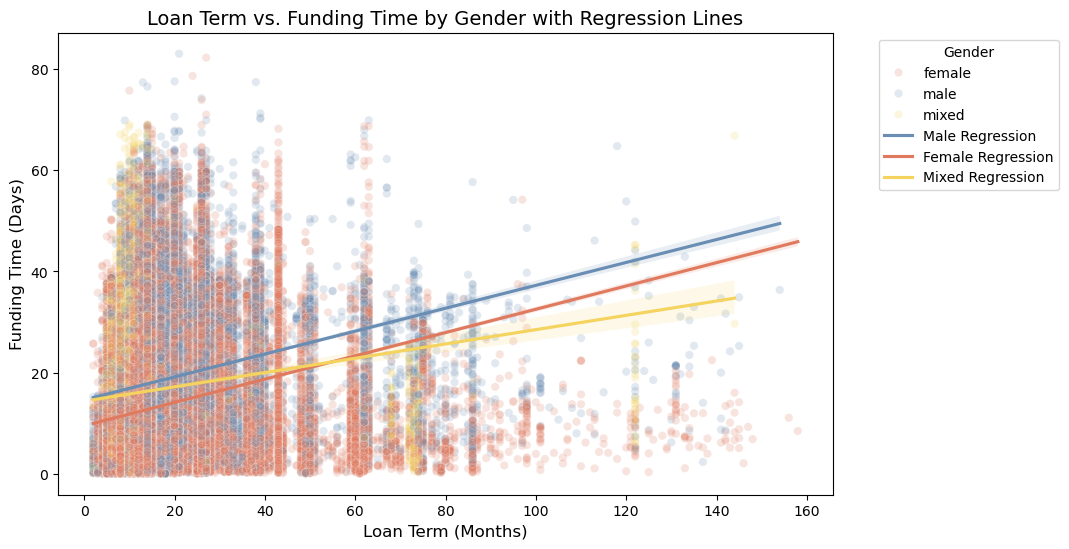

In [144]:
# Define softer color mapping for gender groups
gender_colors = {'male': '#6A8DB3', 'female': '#E07A5F', 'mixed': '#F4D35E'}  # Softer blue, red, yellow

# Set figure size
plt.figure(figsize=(10, 6))

# Scatter plot with softer colors
sns.scatterplot(data=final_df, x='lender_term', y='funding_time_days', hue='gender_group',
                palette=gender_colors, alpha=0.2)

# Add regression lines with corresponding colors
for gender, color in gender_colors.items():
    subset = final_df[final_df['gender_group'] == gender]
    sns.regplot(data=subset, x='lender_term', y='funding_time_days',
                scatter=False, color=color, label=f"{gender.capitalize()} Regression")

# Labels and title
plt.xlabel('Loan Term (Months)', fontsize=12)
plt.ylabel('Funding Time (Days)', fontsize=12)
plt.title('Loan Term vs. Funding Time by Gender with Regression Lines', fontsize=14)

# Move legend outside
plt.legend(title='Gender', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show plot
plt.show()


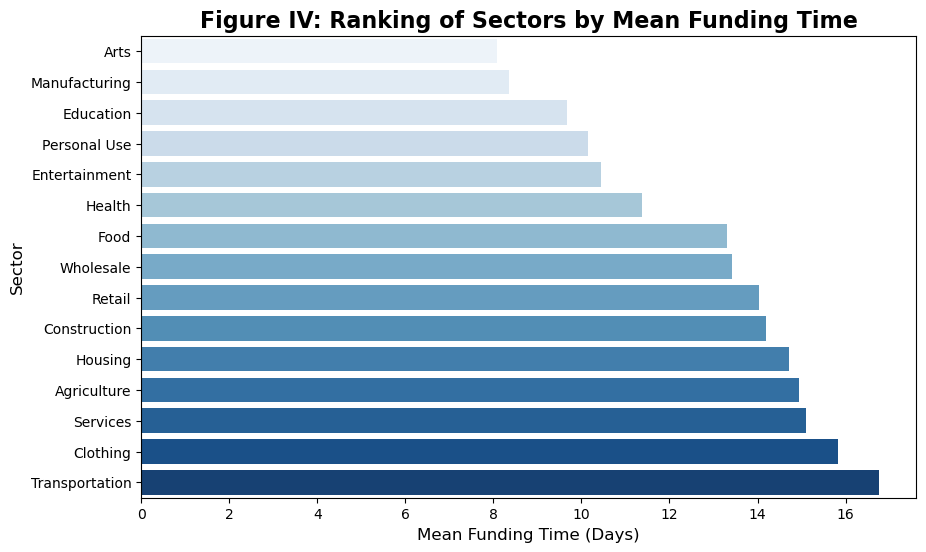

In [100]:

# Calculate mean funding time for each sector
sector_funding_means = final_df.groupby('sector')['funding_time_days'].mean().sort_values(ascending=True)

# Set figure size
plt.figure(figsize=(10, 6))

# Create bar plot with corrected palette (Blues instead of Blues_r)
sns.barplot(x=sector_funding_means.values, y=sector_funding_means.index, hue=sector_funding_means.index, palette='Blues', legend=False)

# Labels and title
plt.xlabel('Mean Funding Time (Days)', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.title('Figure IV: Ranking of Sectors by Mean Funding Time', fontsize=16, fontweight='bold')

# Display the plot
plt.show()


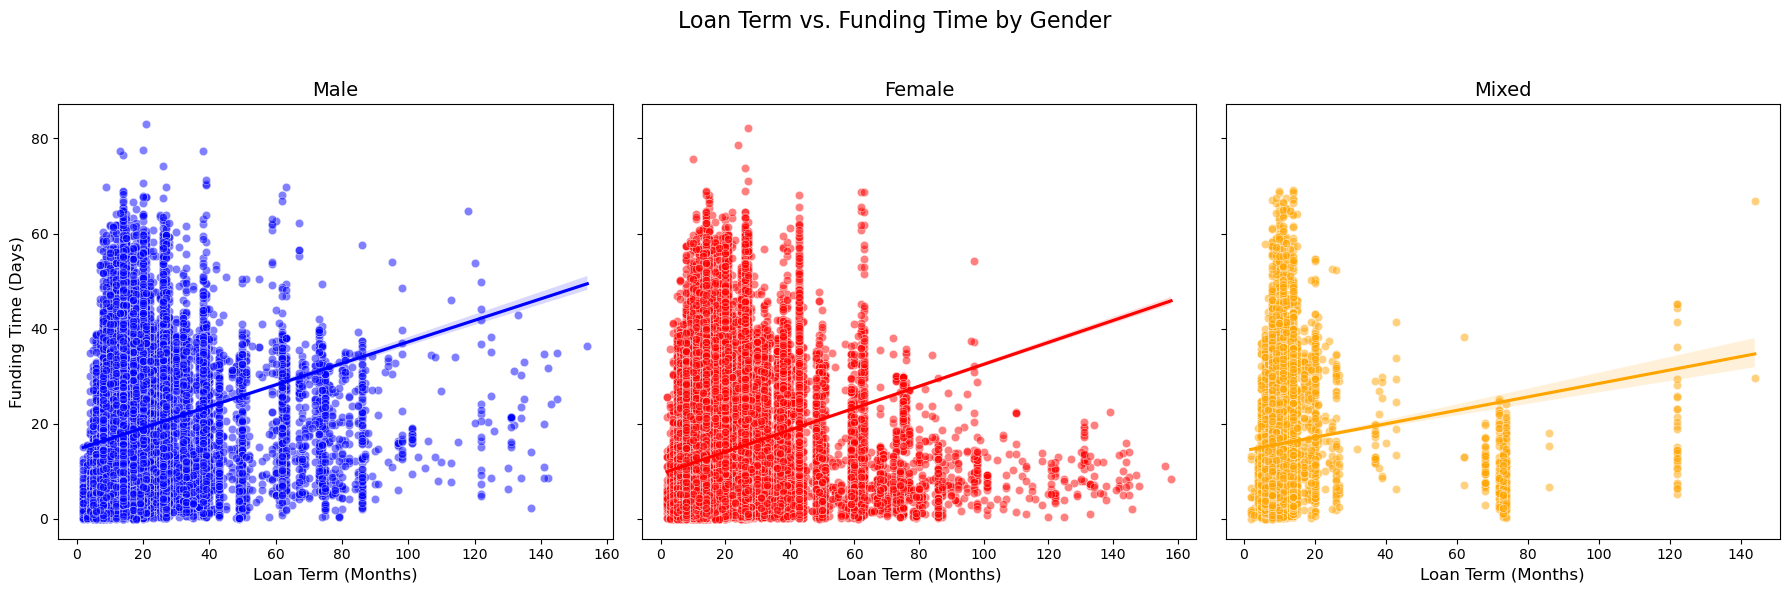

In [236]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure gender values are lowercase and cleaned
final_df['gender_group'] = final_df['gender_group'].str.lower().str.strip()

# Gender colors mapping
gender_mapping = {'male': 'blue', 'female': 'red', 'mixed': 'orange'}

# Set up subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Set overall title
fig.suptitle('Loan Term vs. Funding Time by Gender', fontsize=16)

# Loop through each gender and plot scatter + regression
for ax, (gender, color) in zip(axes, gender_mapping.items()):
    subset = final_df[final_df['gender_group'] == gender]  # Ensure lowercase match
    
    if subset.empty:
        ax.set_title(f'No Data for {gender.capitalize()}')
        continue  # Skip empty plots

    # Scatter plot
    sns.scatterplot(
        x=subset['lender_term'], 
        y=subset['funding_time_days'], 
        color=color, 
        alpha=0.5, 
        ax=ax
    )

    # Regression line
    sns.regplot(
        x=subset['lender_term'], 
        y=subset['funding_time_days'], 
        scatter=False, 
        color=color, 
        ax=ax
    )

    # Titles and labels
    ax.set_title(f'{gender.capitalize()}', fontsize=14)
    ax.set_xlabel('Loan Term (Months)', fontsize=12)

# Common y-axis label
axes[0].set_ylabel('Funding Time (Days)', fontsize=12)

# Adjust layout and show plot
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit title
plt.show()


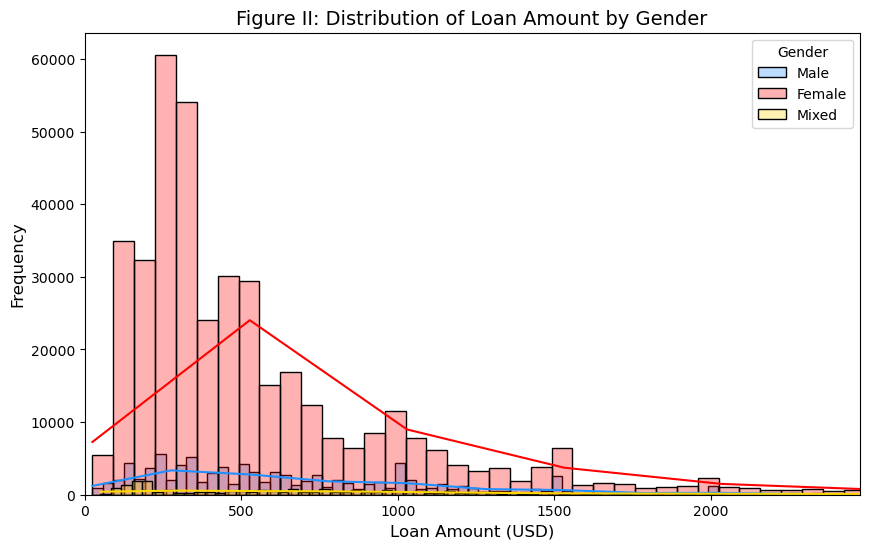

In [224]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define gender groups
male_loan_amount = final_df.loc[final_df['gender_group_male'] == 1, 'loan_amount']
female_loan_amount = final_df.loc[(final_df['gender_group_male'] == 0) & (final_df['gender_group_mixed'] == 0), 'loan_amount']
mixed_loan_amount = final_df.loc[final_df['gender_group_mixed'] == 1, 'loan_amount']

# Set dynamic x-axis limit (95th percentile)
max_x = final_df['loan_amount'].quantile(0.95)

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(male_loan_amount, bins=1500, kde=True, color='dodgerblue', label='Male', alpha=0.3, linewidth=1, common_norm=False)
sns.histplot(female_loan_amount, bins=1500, kde=True, color='red', label='Female', alpha=0.3, linewidth=1, common_norm=False)
sns.histplot(mixed_loan_amount, bins=1500, kde=True, color='gold', label='Mixed', alpha=0.3, linewidth=1, common_norm=False)

# Labels and title
plt.xlabel('Loan Amount (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Figure II: Distribution of Loan Amount by Gender', fontsize=14)
plt.legend(title="Gender")

# Set x-axis limit to filter out extreme outliers
plt.xlim(0, max_x)

# Show the plot
plt.show()


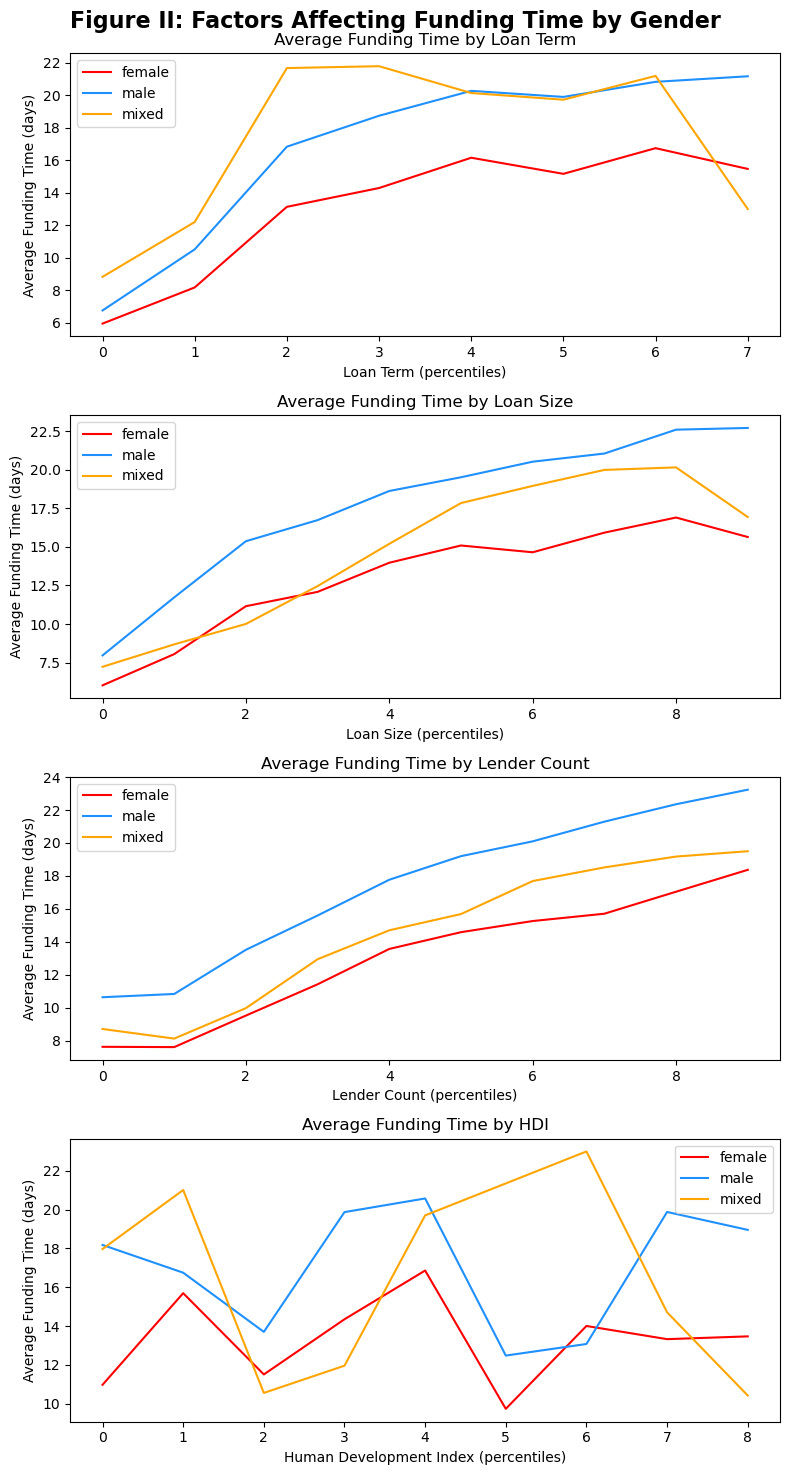

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Function to compute percentiles safely
def compute_percentiles(df, x_col, y_col, group_col, num_bins=10):
    df = df[[x_col, y_col, group_col]].dropna()
    
    # Ensure there is variation in the x_col to allow proper binning
    if df[x_col].nunique() < num_bins:
        print(f"Warning: {x_col} has fewer unique values than bins. Adjusting bin count.")
        num_bins = df[x_col].nunique()  # Reduce bins if not enough unique values
    
    # Bin data using qcut, fallback to cut if necessary
    try:
        df['percentile'] = pd.qcut(df[x_col], q=num_bins, labels=False, duplicates='drop')
    except ValueError:
        df['percentile'] = pd.cut(df[x_col], bins=np.linspace(df[x_col].min(), df[x_col].max(), num_bins), labels=False, include_lowest=True)
    
    return df.groupby(['percentile', group_col])[y_col].mean().reset_index()

# Compute percentiles
avg_funding_by_term = compute_percentiles(final_df, 'term_in_months', 'funding_time_days', 'gender_group')
avg_funding_by_size = compute_percentiles(final_df, 'loan_amount', 'funding_time_days', 'gender_group')
avg_funding_by_lender = compute_percentiles(final_df, 'lender_count', 'funding_time_days', 'gender_group')
avg_funding_by_hdi = compute_percentiles(final_df, 'hdi', 'funding_time_days', 'gender_group')

# Custom color mapping
color_mapping = {
    'male': 'dodgerblue',
    'mixed': 'orange',
    'female': 'red'
}

# Create figure and axes
fig, axes = plt.subplots(4, 1, figsize=(8, 15))

# Define plot function
def plot_funding_time(ax, data, title, xlabel):
    for gender in final_df['gender_group'].unique():
        subset = data[data['gender_group'] == gender]
        if not subset.empty:
            ax.plot(subset['percentile'], subset['funding_time_days'], label=gender, color=color_mapping.get(gender, 'black'))
    ax.set_title(title)
    ax.set_xlabel(xlabel + ' (percentiles)')
    ax.set_ylabel('Average Funding Time (days)')
    ax.legend()

# Generate plots with correct indexing
plot_funding_time(axes[0], avg_funding_by_term, 'Average Funding Time by Loan Term', 'Loan Term')
plot_funding_time(axes[1], avg_funding_by_size, 'Average Funding Time by Loan Size', 'Loan Size')
plot_funding_time(axes[2], avg_funding_by_lender, 'Average Funding Time by Lender Count', 'Lender Count')
plot_funding_time(axes[3], avg_funding_by_hdi, 'Average Funding Time by HDI', 'Human Development Index')  # FIXED: uses axes[3]

# Set overall title
fig.suptitle('Figure II: Factors Affecting Funding Time by Gender', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


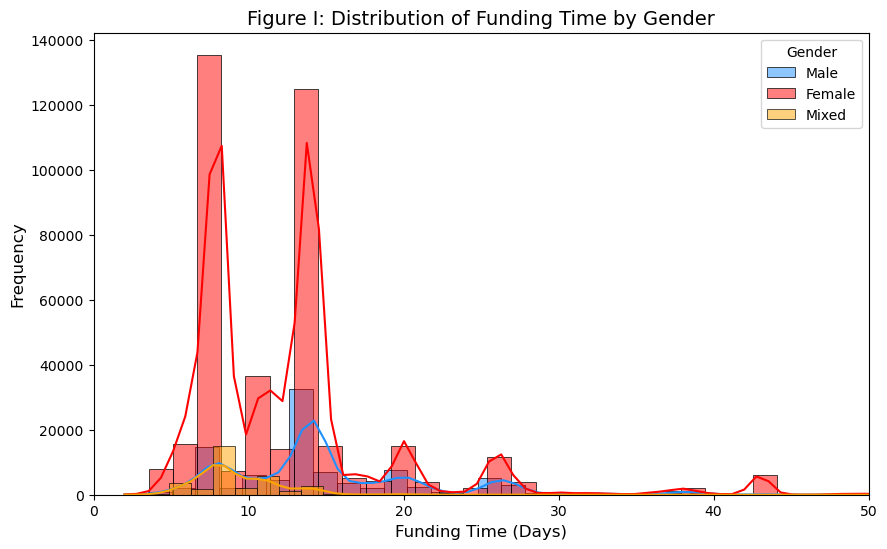

In [262]:
import matplotlib.colors as mcolors

# Define gender groups
male_loan_terms = final_df.loc[final_df['gender_group_male'] == 1, 'term_in_months']
female_loan_terms = final_df.loc[(final_df['gender_group_male'] == 0) & (final_df['gender_group_mixed'] == 0), 'term_in_months']
mixed_loan_terms = final_df.loc[final_df['gender_group_mixed'] == 1, 'term_in_months']

# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(male_loan_terms, bins=100, kde=True, color='dodgerblue', label='Male', alpha=0.5)
sns.histplot(female_loan_terms, bins=100, kde=True, color='red', label='Female', alpha=0.5)
sns.histplot(mixed_loan_terms, bins=100, kde=True, color='orange', label='Mixed', alpha=0.5)

# Labels and title
plt.xlabel('Funding Time (Days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Figure I: Distribution of Loan Terms by Gender', fontsize=14)
plt.legend(title="Gender")

# Set x-axis limit to filter out extreme outliers
plt.xlim(0, 50)

# Show the plot
plt.show()


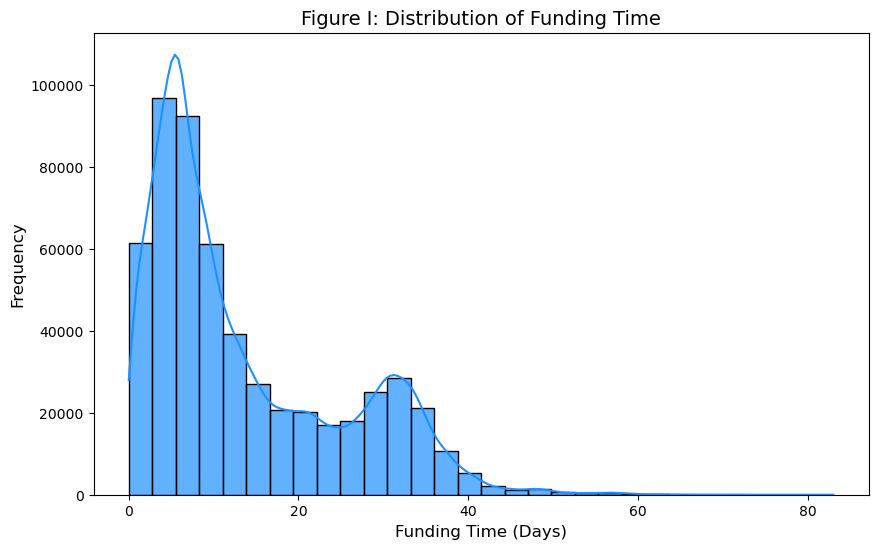

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the histogram without gender separation
plt.figure(figsize=(10, 6))
sns.histplot(final_df['funding_time_days'], bins=30, kde=True, color='dodgerblue', alpha=0.7)

# Labels and title
plt.xlabel('Funding Time (Days)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Figure I: Distribution of Funding Time', fontsize=14)

# Show the plot
plt.show()


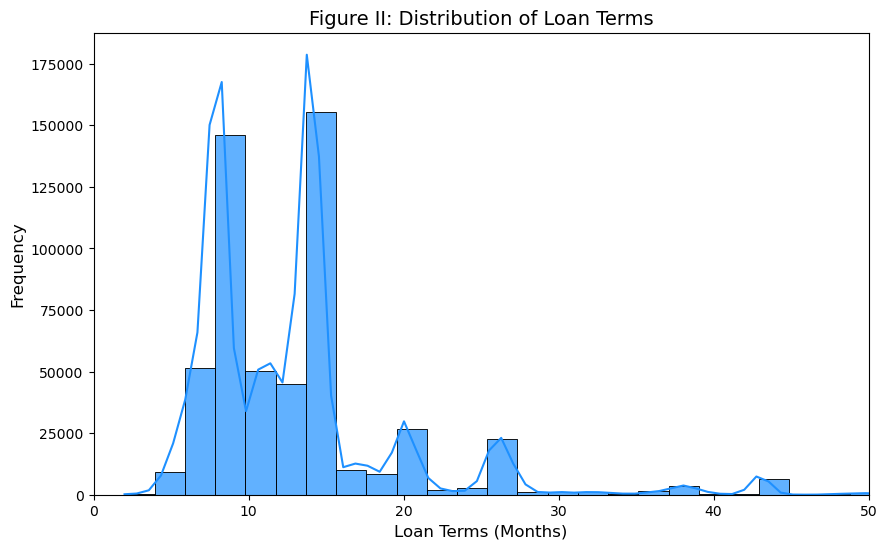

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the histogram without gender separation
plt.figure(figsize=(10, 6))
sns.histplot(final_df['term_in_months'], bins=80, kde=True, color='dodgerblue', alpha=0.7)

# Labels and title
plt.xlabel('Loan Terms (Months)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Figure II: Distribution of Loan Terms', fontsize=14)

plt.xlim(0, 50)

# Show the plot
plt.show()

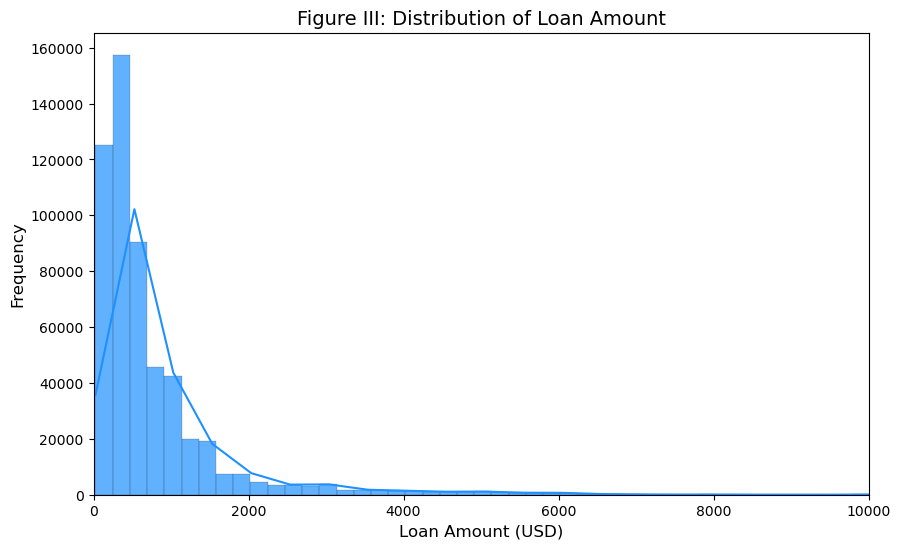

In [288]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the histogram without gender separation
plt.figure(figsize=(10, 6))
sns.histplot(final_df['loan_amount'], bins=450, kde=True, color='dodgerblue', alpha=0.7)

# Labels and title
plt.xlabel('Loan Amount (USD)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Figure III: Distribution of Loan Amount', fontsize=14)

plt.xlim(0, 10000)

# Show the plot
plt.show()

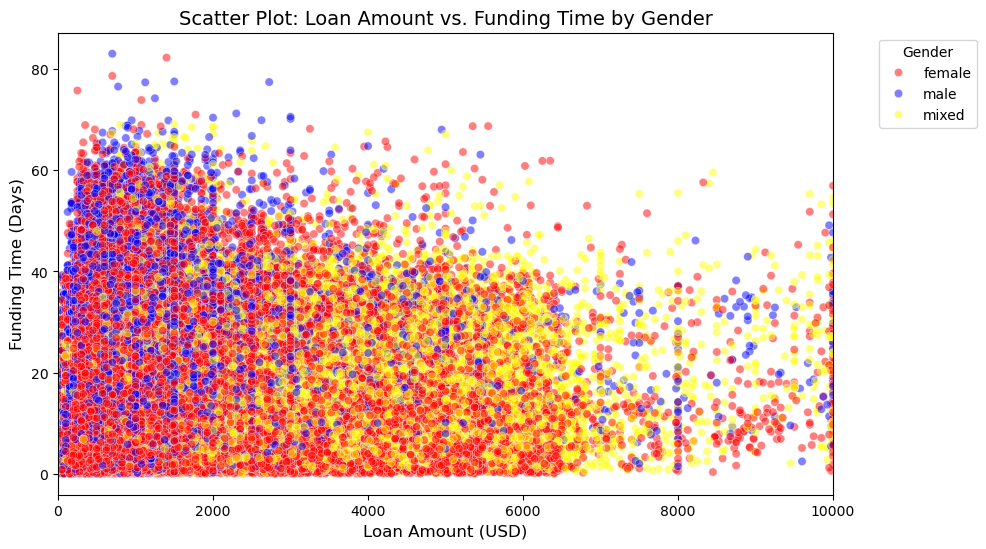

In [296]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(10, 6))

# Create scatter plot
sns.scatterplot(
    data=final_df,
    x="loan_amount",
    y="funding_time_days",
    hue="gender_group",  # Assuming gender_group has values like 'male', 'female', 'mixed'
    palette={"male": "blue", "female": "red", "mixed": "yellow"},
    alpha=0.5
)

# Labels and title
plt.xlabel("Loan Amount (USD)", fontsize=12)
plt.ylabel("Funding Time (Days)", fontsize=12)
plt.title("Scatter Plot: Loan Amount vs. Funding Time by Gender", fontsize=14)

# Move legend outside
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")

# Set x-axis limit to filter out extreme outliers (adjust as needed)
plt.xlim(0, 10000)  # Example limit, change as needed

# Show plot
plt.show()


/var/folders/11/xm61jt5j3bgcdskv3tnccjdh0000gn/T/ipykernel_70097/638302977.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


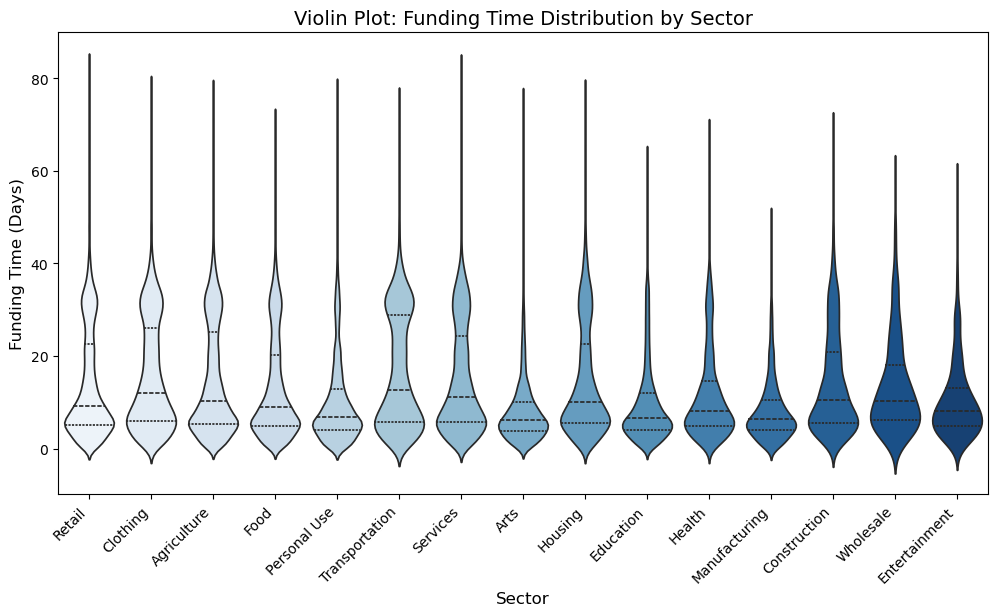

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(12, 6))

# Create violin plot
sns.violinplot(
    data=final_df,
    x="sector",  # Assuming this column contains sector names
    y="funding_time_days",  # Assuming 'lender_term' represents loan term in months
    palette="Blues",
    inner="quartile"  # Shows quartiles within the violin
)

# Labels and title
plt.xlabel("Sector", fontsize=12)
plt.ylabel("Funding Time (Days)", fontsize=12)
plt.title("Violin Plot: Funding Time Distribution by Sector", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# Show plot
plt.show()


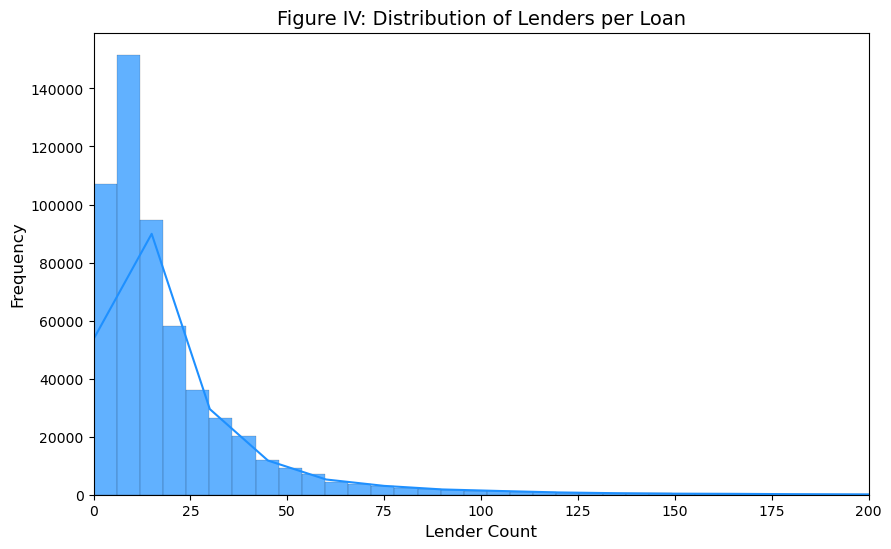

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create the histogram without gender separation
plt.figure(figsize=(10, 6))
sns.histplot(final_df['lender_count'], bins=500, kde=True, color='dodgerblue', alpha=0.7)

# Labels and title
plt.xlabel('Lender Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Figure IV: Distribution of Lenders per Loan', fontsize=14)

plt.xlim(0, 200)

# Show the plot
plt.show()

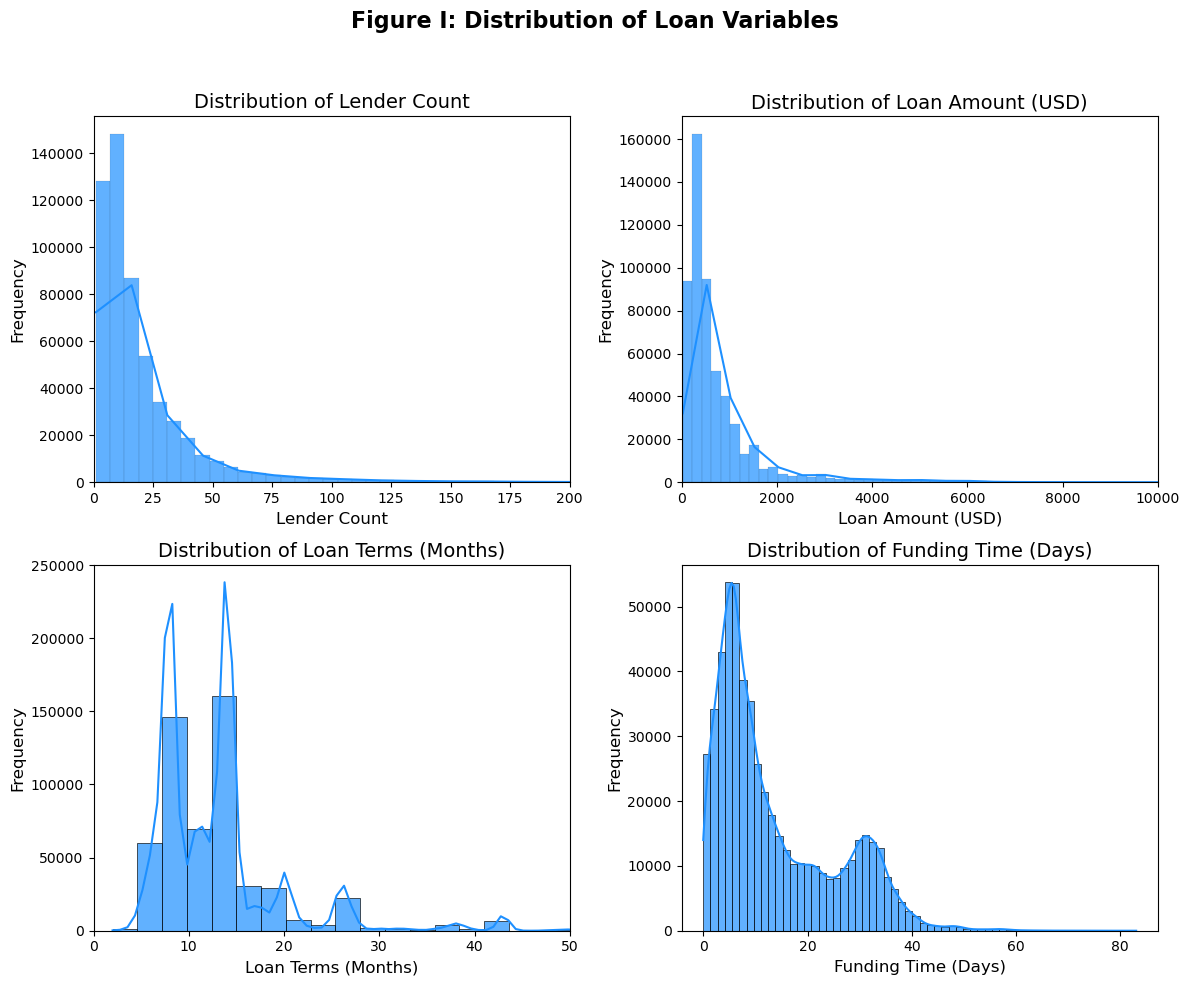

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(12, 10))  # Adjust figure size
fig.suptitle('Figure I: Distribution of Loan Variables', fontsize=16, fontweight='bold')

# Define variables, titles, x-limits, and **custom bin sizes**
variables = [
    ('num_lenders_total', 'Lender Count', (0, 200), 500),
    ('loan_amount', 'Loan Amount (USD)', (0, 10000), 500),  
    ('term_in_months', 'Loan Terms (Months)', (0, 50), 60),  # 30 bins
    ('funding_time_days', 'Funding Time (Days)', None, 60)  # 60 bins
]

# Loop through subplots and plot histograms
for ax, (var, xlabel, xlim, bins) in zip(axes.flatten(), variables):
    sns.histplot(final_df[var], bins=bins, kde=True, color='dodgerblue', alpha=0.7, ax=ax)
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.set_title(f'Distribution of {xlabel}', fontsize=14)
    if xlim:
        ax.set_xlim(xlim)  # Apply x-limit if specified

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for suptitle
plt.show()


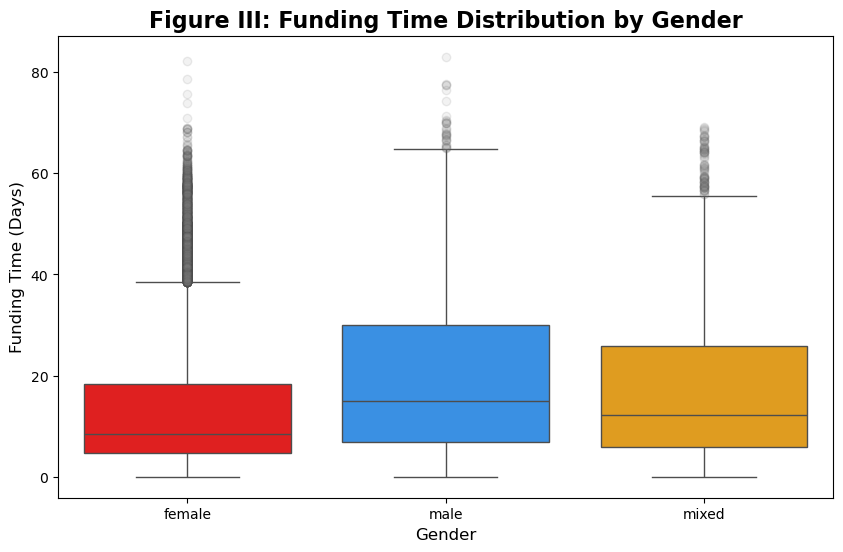

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(10, 6))

# Define custom colors
palette = {"male": "dodgerblue", "female": "red", "mixed": "orange"}

# Create the box plot with explicit hue assignment
sns.boxplot(
    x="gender_group",
    y="funding_time_days",
    hue="gender_group",  # Explicitly set hue to avoid the deprecation warning
    data=final_df,
    palette=palette,
    legend=False,  # Remove legend as it's redundant with x-axis labels
    flierprops={'marker': 'o', 'markerfacecolor': 'grey', 'alpha': 0.1}  # Make outliers transparent
)

# Labels and title
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Funding Time (Days)", fontsize=12)
plt.title("Figure III: Funding Time Distribution by Gender", fontsize=16, fontweight="bold")

# Show plot
plt.show()


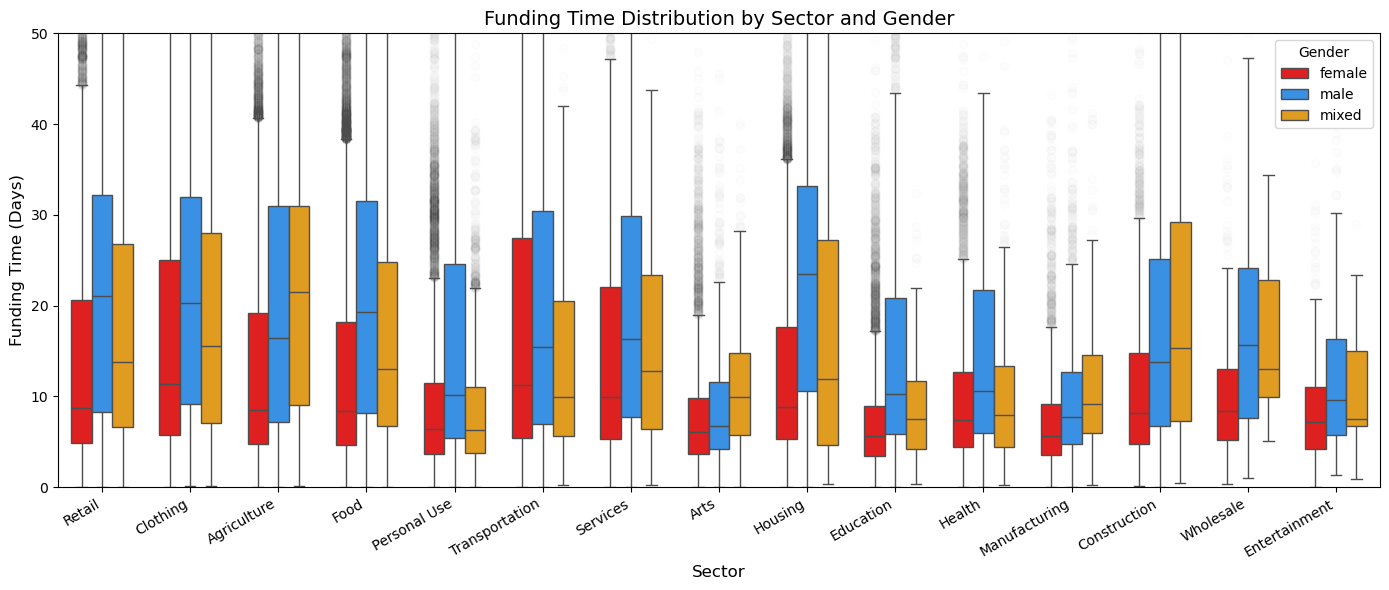

In [90]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(14, 6))

# Define custom colors
palette = {"female": "red", "male": "dodgerblue", "mixed": "orange"}

# Create the box plot with transparent outliers
sns.boxplot(
    data=final_df,
    x="sector",
    y="funding_time_days",
    hue="gender_group",
    palette=palette,
    width=0.7,  # Adjusted box width
    flierprops={'marker': 'o', 'markerfacecolor': 'grey', 'alpha': 0.01}  # Make outliers transparent
)

# Adjustments
plt.ylim(0, 50)  # Set y-axis limit
plt.xticks(rotation=30, ha="right")  # Rotate x-axis labels

# Labels and title
plt.xlabel("Sector", fontsize=12)
plt.ylabel("Funding Time (Days)", fontsize=12)
plt.title("Funding Time Distribution by Sector and Gender", fontsize=14)

# Adjust legend placement
plt.legend(title="Gender", loc="upper right")

# Show plot
plt.tight_layout()
plt.show()


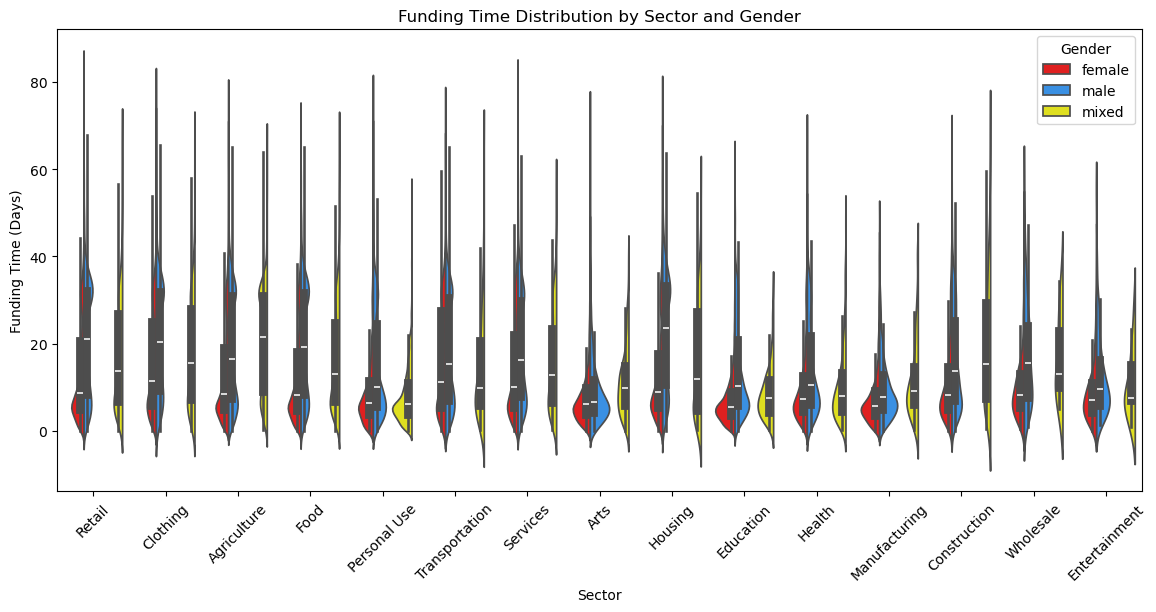

In [68]:
plt.figure(figsize=(14, 6))
sns.violinplot(x="sector", y="funding_time_days", hue="gender_group", data=final_df, split=True, palette={"male": "dodgerblue", "female": "red", "mixed": "yellow"})
plt.xticks(rotation=45)
plt.xlabel("Sector")
plt.ylabel("Funding Time (Days)")
plt.title("Funding Time Distribution by Sector and Gender")
plt.legend(title="Gender")
plt.show()


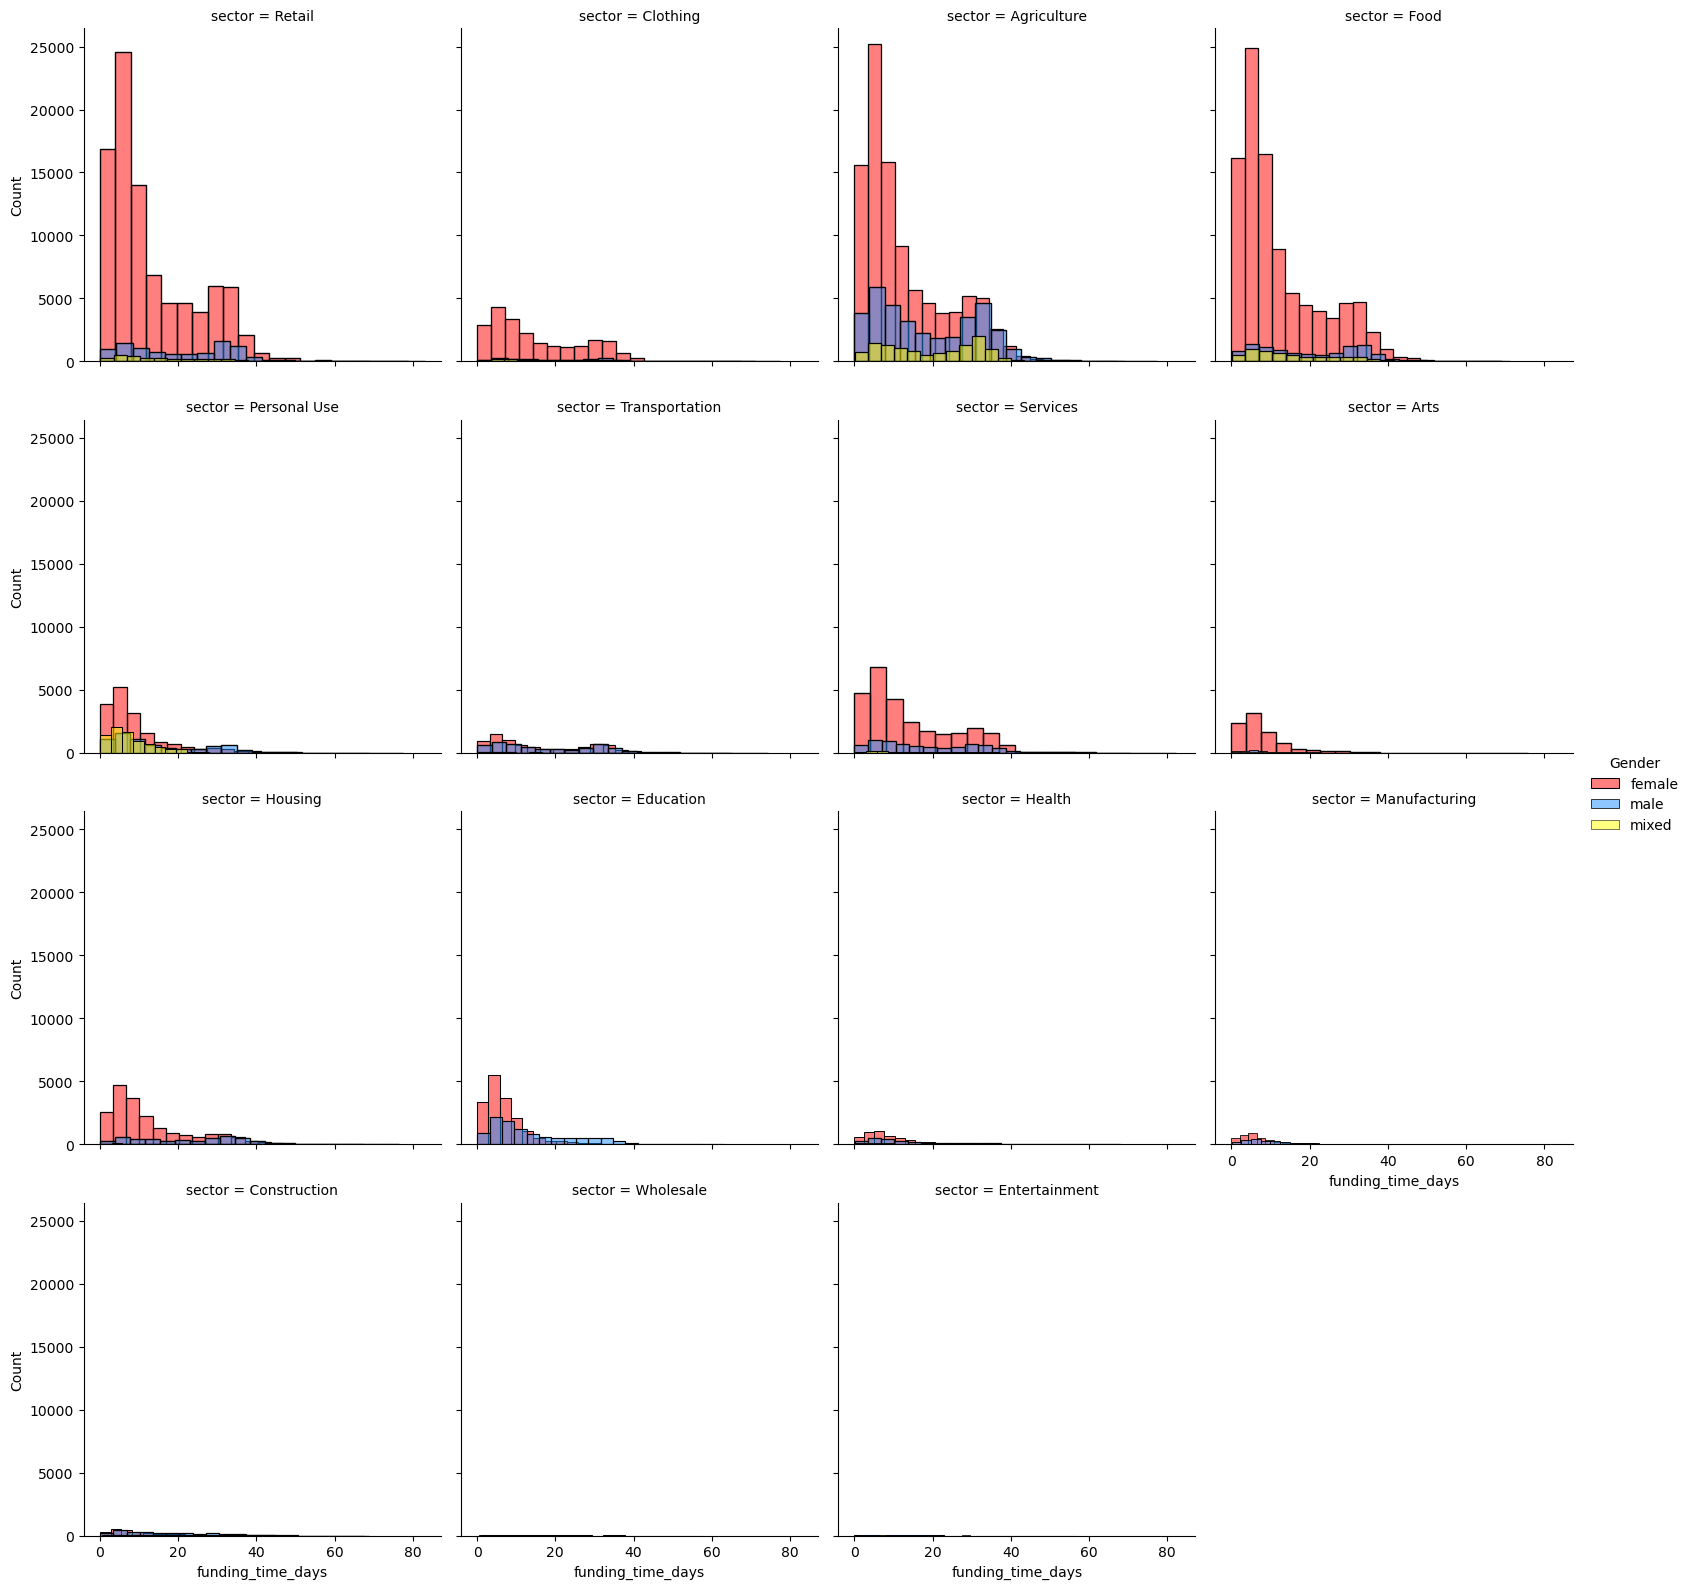

In [70]:
g = sns.FacetGrid(final_df, col="sector", hue="gender_group", col_wrap=4, height=4, palette={"male": "dodgerblue", "female": "red", "mixed": "yellow"})
g.map(sns.histplot, "funding_time_days", bins=20, alpha=0.5)
g.add_legend(title="Gender")
plt.show()


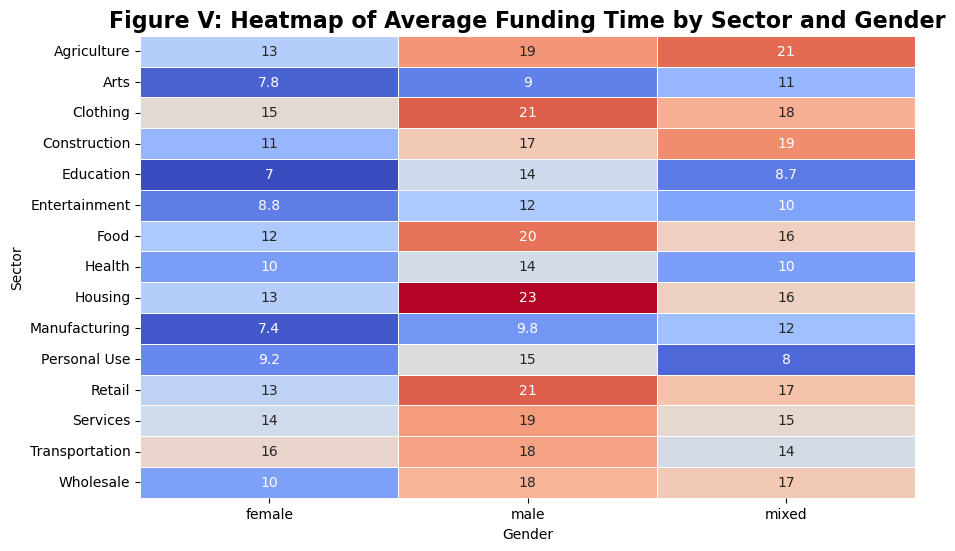

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create pivot table
pivot_df = final_df.pivot_table(index="sector", columns="gender_group", values="funding_time_days", aggfunc="mean")

# Set figure size
plt.figure(figsize=(10, 6))

# Create heatmap without the color bar
sns.heatmap(pivot_df, annot=True, cmap="coolwarm", linewidths=0.5, cbar=False)

# Labels and title
plt.xlabel("Gender")
plt.ylabel("Sector")
plt.title("Figure V: Heatmap of Average Funding Time by Sector and Gender", fontsize=16, fontweight="bold")

# Show plot
plt.show()